<a href="https://colab.research.google.com/github/VitalyGladyshev/gb_nlp/blob/main/%D0%93%D0%BB%D0%B0%D0%B4%D1%8B%D1%88%D0%B5%D0%B2%D0%92%D0%92_NLP_HW_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ 10 Гладышев ВВ

## Модель seq2seq

### Посимвольно

In [1]:
import numpy as np
import tensorflow as tf
import string
from tqdm import tqdm
import os

In [2]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

In [3]:
!wget http://www.manythings.org/anki/rus-eng.zip

--2024-03-06 14:49:27--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16065699 (15M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  15.32M  53.1MB/s    in 0.3s    

2024-03-06 14:49:28 (53.1 MB/s) - ‘rus-eng.zip’ saved [16065699/16065699]



In [4]:
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/

Archive:  rus-eng.zip
  inflating: rus-eng/rus.txt         
  inflating: rus-eng/_about.txt      


In [21]:
batch_size = 256
epochs = 70
latent_dim = 256
num_samples = 20000
data_path = '/content/rus-eng/rus.txt'

In [22]:
# Собираем из текстов токены и делаем one-hot вектора на каждый токен

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [23]:
input_characters[:15], input_characters[-15:]

([' ', '!', '"', '$', '%', '&', "'", ',', '-', '.', '0', '1', '2', '3', '4'],
 ['m', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é'])

In [24]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

In [25]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [26]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

In [27]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

Epoch 1/70
63/63 [==============================] - 7s 49ms/step - loss: 1.4685 - accuracy: 0.7544 - val_loss: 1.1857 - val_accuracy: 0.7398
Epoch 2/70
63/63 [==============================] - 2s 29ms/step - loss: 0.9155 - accuracy: 0.7678 - val_loss: 0.9586 - val_accuracy: 0.7432
Epoch 3/70
63/63 [==============================] - 2s 29ms/step - loss: 0.8067 - accuracy: 0.7774 - val_loss: 0.8870 - val_accuracy: 0.7604
Epoch 4/70
63/63 [==============================] - 2s 31ms/step - loss: 0.7432 - accuracy: 0.8028 - val_loss: 0.8220 - val_accuracy: 0.7812
Epoch 5/70
63/63 [==============================] - 2s 33ms/step - loss: 0.6820 - accuracy: 0.8211 - val_loss: 0.7549 - val_accuracy: 0.8002
Epoch 6/70
63/63 [==============================] - 2s 34ms/step - loss: 0.6242 - accuracy: 0.8314 - val_loss: 0.7038 - val_accuracy: 0.8058
Epoch 7/70
63/63 [==============================] - 2s 29ms/step - loss: 0.5848 - accuracy: 0.8373 - val_loss: 0.6716 - val_accuracy: 0.8108
Epoch 8/70
63

In [32]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq, verbose=None)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=None)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence

In [33]:
for seq_index in range(0, 20000, 500):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Подожди.

-
Input sentence: Who ate?
Decoded sentence: Кто это сделал?

-
Input sentence: Touch it.
Decoded sentence: Потрогай её.

-
Input sentence: I'm dirty.
Decoded sentence: Я прованился.

-
Input sentence: Tom's shy.
Decoded sentence: Том в стреня.

-
Input sentence: I envy you.
Decoded sentence: Я вазадую тебя.

-
Input sentence: It's green.
Decoded sentence: Оно застренно.

-
Input sentence: We'll cook.
Decoded sentence: Мы пойдём.

-
Input sentence: Have a look.
Decoded sentence: Поеходи.

-
Input sentence: I saved you.
Decoded sentence: Я вас разбила.

-
Input sentence: Is it there?
Decoded sentence: Он странно?

-
Input sentence: Stop crying.
Decoded sentence: Перестань хратиться!

-
Input sentence: We miss you.
Decoded sentence: Мы слышали это.

-
Input sentence: Are you tall?
Decoded sentence: Ты в порядке?

-
Input sentence: Hey, wake up!
Decoded sentence: Эй, проснить!

-
Input sentence: I was lonely.
Decoded sentence: Я была занят

## Уровень слов

In [34]:
import re
# import tensorflow.compat.v1 as tf
import tensorflow as tf

In [36]:
# tf.enable_eager_execution()

input_texts = []
target_texts = []

def preprocess_sentence(w):
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

def preprocess_sentence_rus(w):
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^а-яА-Я?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(preprocess_sentence(input_text))
    target_texts.append(preprocess_sentence_rus(target_text))

In [37]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    return tensor, lang_tokenizer

In [38]:
input_tensor, inp_lang_tokenizer = tokenize(input_texts)
target_tensor, targ_lang_tokenizer = tokenize(target_texts)

In [39]:
from sklearn.model_selection import train_test_split

input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [40]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [41]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True)

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.lstm(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.lstm(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

In [42]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [43]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [44]:
EPOCHS = 35
for epoch in range(EPOCHS):
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))

Epoch 1 Loss 1.6509
Epoch 2 Loss 1.1737
Epoch 3 Loss 0.9304
Epoch 4 Loss 0.7179
Epoch 5 Loss 0.5353
Epoch 6 Loss 0.4087
Epoch 7 Loss 0.3243
Epoch 8 Loss 0.2696
Epoch 9 Loss 0.2349
Epoch 10 Loss 0.2100
Epoch 11 Loss 0.1935
Epoch 12 Loss 0.1805
Epoch 13 Loss 0.1727
Epoch 14 Loss 0.1667
Epoch 15 Loss 0.1602
Epoch 16 Loss 0.1540
Epoch 17 Loss 0.1503
Epoch 18 Loss 0.1469
Epoch 19 Loss 0.1433
Epoch 20 Loss 0.1411
Epoch 21 Loss 0.1411
Epoch 22 Loss 0.1381
Epoch 23 Loss 0.1345
Epoch 24 Loss 0.1324
Epoch 25 Loss 0.1306
Epoch 26 Loss 0.1297
Epoch 27 Loss 0.1274
Epoch 28 Loss 0.1263
Epoch 29 Loss 0.1243
Epoch 30 Loss 0.1221
Epoch 31 Loss 0.1203
Epoch 32 Loss 0.1188
Epoch 33 Loss 0.1177
Epoch 34 Loss 0.1171
Epoch 35 Loss 0.1179


In [45]:
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

def translate(sentence, show=True):
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}\n'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    if show:
        plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [46]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'char']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Input: <start> good morning <end>
Predicted translation: доброе утро . <end> 



<ipython-input-45-6ae2198bd1af>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-45-6ae2198bd1af>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


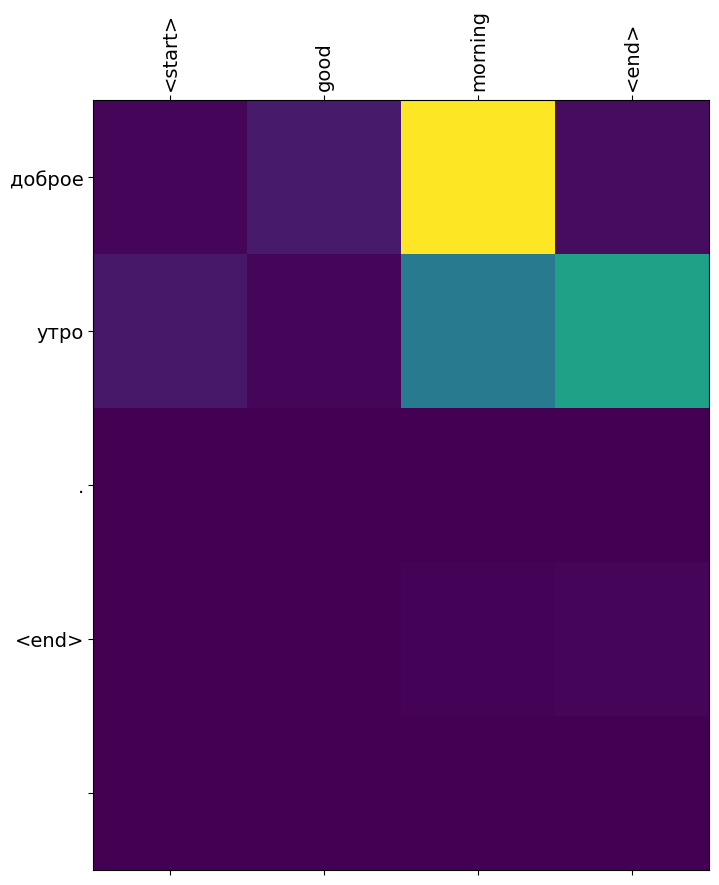

In [47]:
translate(u'good morning')

In [48]:
for seq_index in range(0, 20000, 500):
    string_i = input_texts[seq_index]
    translate(string_i[7:-5].lower(), False)

Input: <start> go . <end>
Predicted translation: идите . <end> 

Input: <start> who ate ? <end>
Predicted translation: кто съел ? <end> 

Input: <start> touch it . <end>
Predicted translation: потрогайте его . <end> 

Input: <start> i m dirty . <end>
Predicted translation: я грязная . <end> 

Input: <start> tom s shy . <end>
Predicted translation: том робкий . <end> 

Input: <start> i envy you . <end>
Predicted translation: я тебе завидую . <end> 

Input: <start> it s green . <end>
Predicted translation: оно зел ное . <end> 

Input: <start> we ll cook . <end>
Predicted translation: мы будем готовить . <end> 

Input: <start> have a look . <end>
Predicted translation: посмотри . <end> 

Input: <start> i saved you . <end>
Predicted translation: я вас спас . <end> 

Input: <start> is it there ? <end>
Predicted translation: он там ? <end> 

Input: <start> stop crying . <end>
Predicted translation: хватит лить сл зы ! <end> 

Input: <start> we miss you . <end>
Predicted translation: мы по те